In [1]:
import decode_eeg
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
np.random.seed(42)
%load_ext autoreload
%autoreload 2

In [2]:
experiment_name = 'C01'
data_dir = f'./data/{experiment_name}'
exp = decode_eeg.Experiment(experiment_name,data_dir,test=False)

In [3]:
time_window = 50
time_step = 25
trial_average = 20
n_splits = 1000
group_dict = {0:[11],1:[12],2:[13],3:[20]}
# group_dict = {0:[11],1:[20]}

wrangl = decode_eeg.Wrangler(exp.info['times'],time_window,time_step,trial_average,n_splits,group_dict)
clfr = decode_eeg.Classification(wrangl,exp.nsub,num_labels=4)

In [4]:

clfr.confidence_scores = np.empty((exp.nsub,len(wrangl.t),wrangl.n_splits,clfr.num_labels))
preds = np.empty((exp.nsub,len(wrangl.t),wrangl.n_splits,clfr.num_labels))
acc = np.empty((exp.nsub,len(wrangl.t),wrangl.n_splits,2),dtype=int)

for isub in range(exp.nsub):
    print(isub)
    xdata,ydata = exp.load_eeg(isub)

    xdata,ydata = wrangl.setup_data(xdata,ydata)

    for X_train_all, X_test_all, y_train, y_test in wrangl.train_test_split(xdata,ydata):
        
        # remove 4G from training, only train on N1 and 2
        # test on 4G, 2U, and 4U
        X_train_all = X_train_all[((y_train == 0) + (y_train == 3))]
        y_train = y_train[((y_train == 0) + (y_train == 3))] 
        
        # shuffle labels for chance classification
        X_test_all, y_test = wrangl.balance_labels(X_test_all,y_test) 
        y_test_shuffle = np.random.permutation(y_test)

        for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):
            clfr.decode(X_train,X_test,y_train,y_test,y_test_shuffle,isub)
            
            X_train, X_test = clfr.standardize(X_train, X_test)
            confidence_scores = clfr.classifier.decision_function(X_test)
            for i,ss in enumerate(set(y_test)):
                clfr.confidence_scores[isub,wrangl.itime,wrangl.ifold,i] = np.mean(confidence_scores[y_test==ss])
            # clfr.confidence_scores[isub,wrangl.itime,wrangl.ifold] = clfr.classifier.decision_function(X_test)
            # preds[isub,wrangl.itime,wrangl.ifold] = clfr.classifier.predict(X_test)
            
            # # acc[isub,wrangl.itime,wrangl.ifold,0] = np.mean((clfr.classifier.predict(X_test)==y_test))
            # acc[isub,wrangl.itime,wrangl.ifold,1] = clfr.classifier.score(X_test,y_test)
            # print(clfr.classifier.score(X_test,y_test))
            


0
1
2
3


In [6]:
interp = decode_eeg.Interpreter(clfr, subtitle='1vs2_1h1l')
interp.confidence_scores = clfr.confidence_scores
interp.save_results(additional_values=['confidence_scores'])

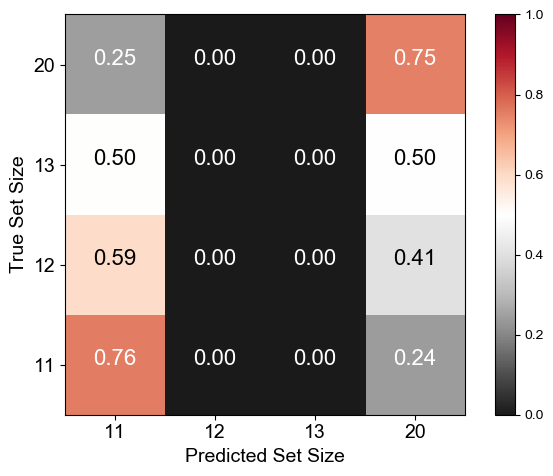

In [7]:
interp.plot_conf_mat(upper=1)

In [8]:
import scipy.stats as sista
def get_plot_line(a):
    """
    Takes in 2D array of shape [subjects,time points].
    Returns mean, and upper/lower SEM lines.
    """
    mean = np.mean(a,0)
    sem = sista.sem(a,0)
    upper,lower = mean + sem, mean - sem
    return mean, upper, lower

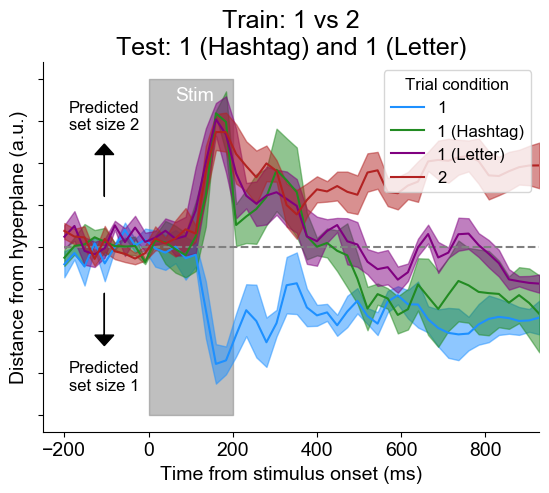

In [10]:
# Get means for each condition
ssn1 = np.mean(interp.confidence_scores,2)[:,:,0]
ssh1 = np.mean(interp.confidence_scores,2)[:,:,1]
ssl1 = np.mean(interp.confidence_scores,2)[:,:,2]
ss2 = np.mean(interp.confidence_scores,2)[:,:,3]

# Plot confidence of classifier, which is proportional to distance from hyperplane.
stim_lower,stim_upper = -4,4
stim_time = [0,200]

ax = plt.subplot(111)

ax.fill_between(stim_time,[stim_lower,stim_lower],[stim_upper,stim_upper],color='gray',alpha=.5)
ax.plot(interp.t,np.zeros((len(interp.t))),'--',color='gray')
colors = ['dodgerblue','forestgreen','purple','firebrick']
# colors = [cmap(0),cmap(0.1),cmap(0.2),cmap(1)]

med, upper, lower = get_plot_line(ssn1)
ax.plot(interp.t,med,colors[0],label = '1')
ax.fill_between(interp.t,upper,lower, color=colors[0],alpha=.5)

med, upper, lower = get_plot_line(ssh1)
ax.plot(interp.t,med,colors[1],label = '1 (Hashtag)')
ax.fill_between(interp.t,upper,lower, color=colors[1], alpha=.5)

med, upper, lower = get_plot_line(ssl1)
ax.plot(interp.t,med,colors[2],label = '1 (Letter)')
ax.fill_between(interp.t,upper,lower, color=colors[2], alpha=.5)

med, upper, lower = get_plot_line(ss2)
ax.plot(interp.t,med,colors[3],label = '2')
ax.fill_between(interp.t,upper,lower, color=colors[3], alpha=.5)

leg = plt.legend(title='Trial condition',loc='upper right',fontsize=12)
plt.setp(leg.get_title(),fontsize=12)

# aesthetics
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.yticks(np.arange(-4,5,1),labels=['','','','','','',''])
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)

plt.xlim(-250,max(interp.t))


# labelling
plt.title('Train: 1 vs 2\nTest: 1 (Hashtag) and 1 (Letter)',fontsize=18)
plt.xlabel('Time from stimulus onset (ms)', fontsize=14)
plt.ylabel('Distance from hyperplane (a.u.)', fontsize=14)

plt.text(-105,-3.4,'Predicted\nset size 1',fontsize=12,ha='center')
plt.text(-105,2.8,'Predicted\nset size 2',fontsize=12,ha='center')
plt.text(110,3.5,'Stim',fontsize=14,ha='center',c='white')
plt.arrow(-105,1.2,0,1, head_width=45, head_length=.25,color='k')
plt.arrow(-105,-1.1,0,-1,head_width=45, head_length=.25,color='k')

plt.savefig('output/figures/hyperplane_1v2_h1l1.png',dpi=500)
# plt.savefig('output/figures/colinearity_hyperplane_testing.pdf',dpi=500)

plt.show()